In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df = pd.read_csv("Bengaluru_House_Data.csv")

In [26]:
df.head(5)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,Super built-up Area,Ready To Move,7th Phase JP Nagar,2 BHK,Shncyes,1000.0,2.0,1.0,38.0,2,3800.000000
1,Built-up Area,Ready To Move,7th Phase JP Nagar,2 BHK,Brnia G,1080.0,2.0,2.0,72.0,2,6666.666667
2,Super built-up Area,Ready To Move,7th Phase JP Nagar,2 BHK,BriumMi,1270.0,2.0,2.0,93.0,2,7322.834646
3,Built-up Area,Ready To Move,7th Phase JP Nagar,3 BHK,Brnia G,1420.0,2.0,1.0,100.0,3,7042.253521
4,Built-up Area,Ready To Move,7th Phase JP Nagar,3 BHK,Brngsal,1850.0,3.0,1.0,150.0,3,8108.108108


In [27]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7014 entries, 0 to 7013
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   area_type       7014 non-null   object 
 1   availability    7014 non-null   object 
 2   location        7014 non-null   object 
 3   size            7014 non-null   object 
 4   society         7014 non-null   object 
 5   total_sqft      7014 non-null   float64
 6   bath            7014 non-null   float64
 7   balcony         7014 non-null   float64
 8   price           7014 non-null   float64
 9   bhk             7014 non-null   int64  
 10  price_per_sqft  7014 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 602.9+ KB
None


In [28]:
print(df.isnull().sum())

area_type         0
availability      0
location          0
size              0
society           0
total_sqft        0
bath              0
balcony           0
price             0
bhk               0
price_per_sqft    0
dtype: int64


In [29]:
print(df.describe())

         total_sqft         bath      balcony        price          bhk  \
count   7014.000000  7014.000000  7014.000000  7014.000000  7014.000000   
mean    1457.000384     2.410180     1.624750    85.104656     2.491731   
std      767.996299     0.823935     0.777586    63.803183     0.704331   
min      350.000000     1.000000     0.000000    10.000000     1.000000   
25%     1112.000000     2.000000     1.000000    49.000000     2.000000   
50%     1300.000000     2.000000     2.000000    67.990000     2.000000   
75%     1627.395000     3.000000     2.000000    99.000000     3.000000   
max    36000.000000     9.000000     3.000000  1000.000000    11.000000   

       price_per_sqft  
count     7014.000000  
mean      5528.210943  
std       1849.665750  
min        500.000000  
25%       4250.214994  
50%       5243.490957  
75%       6498.985399  
max      17741.935484  


In [30]:
print("\nDuplicates:", df.duplicated().sum())


Duplicates: 347


In [31]:
print("\nUnique locations:", df['location'].nunique())
print("Unique area types:", df['area_type'].unique())


Unique locations: 86
Unique area types: ['Super built-up  Area' 'Built-up  Area' 'Carpet  Area' 'Plot  Area']


In [15]:
df = df.dropna()
df['bhk'] = df['size'].apply(lambda x: int(x.split()[0]))
df['total_sqft'] = df['total_sqft'].apply(lambda x: (float(x.split('-')[0]) + float(x.split('-')[1]))/2 if '-' in x else float(x) if x.replace('.','',1).isdigit() else None)
df = df.dropna()

In [16]:
# Remove unrealistic sqft per bhk
df = df[df.total_sqft/df.bhk > 300]

In [17]:
# price_per_sqft
df['price_per_sqft'] = df['price']*100000/df['total_sqft']

In [18]:
df['location'] = df['location'].apply(lambda x: x.strip())
loc_counts = df['location'].value_counts()
df['location'] = df['location'].apply(lambda x: x if loc_counts[x] > 20 else 'other')

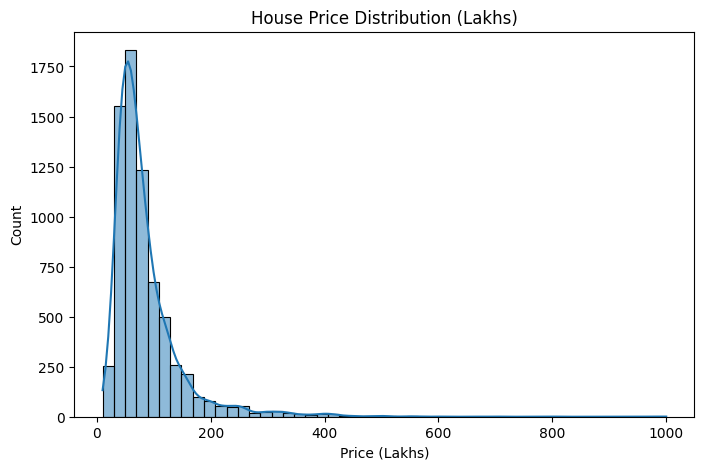

In [32]:
plt.figure(figsize=(8,5))
sns.histplot(df['price'], kde=True, bins=50)
plt.title("House Price Distribution (Lakhs)")
plt.xlabel("Price (Lakhs)")
plt.show()

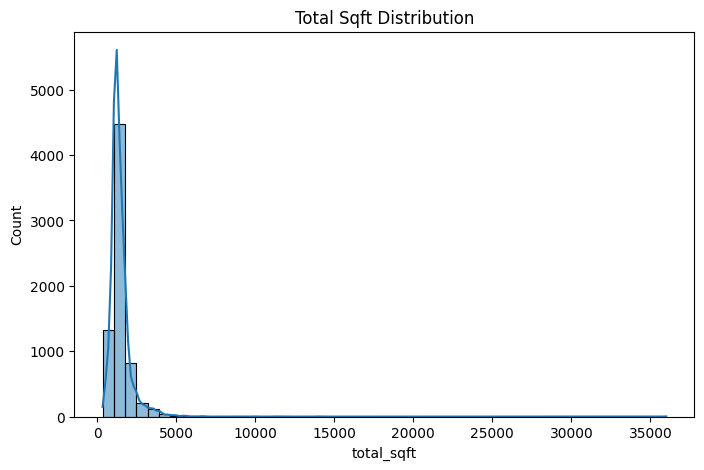

In [33]:
plt.figure(figsize=(8,5))
sns.histplot(df['total_sqft'], kde=True, bins=50)
plt.title("Total Sqft Distribution")
plt.show()


In [19]:
def remove_outliers_pps(df):
    df_out = pd.DataFrame()
    for key, group in df.groupby('location'):
        q1 = group.price_per_sqft.quantile(0.25)
        q3 = group.price_per_sqft.quantile(0.75)
        iqr = q3 - q1
        clean = group[(group.price_per_sqft >= q1 - 1.5*iqr) & (group.price_per_sqft <= q3 + 1.5*iqr)]
        df_out = pd.concat([df_out, clean], ignore_index=True)
    return df_out

df = remove_outliers_pps(df)

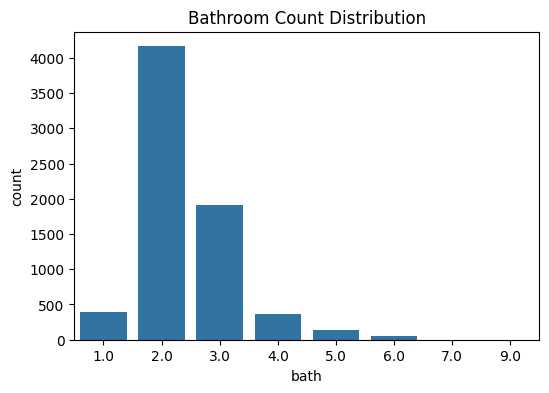

In [34]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['bath'])
plt.title("Bathroom Count Distribution")
plt.show()


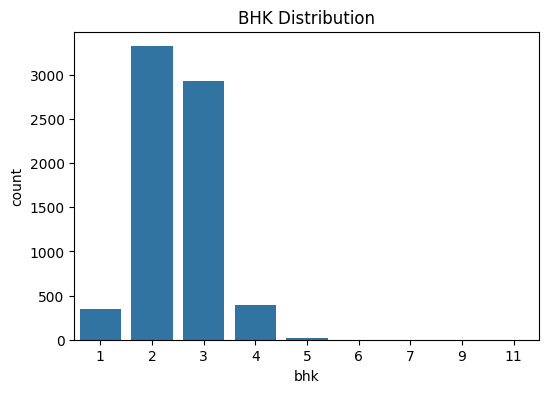

In [35]:
df['bhk'] = df['size'].apply(lambda x: int(x.split()[0]))
plt.figure(figsize=(6,4))
sns.countplot(x=df['bhk'])
plt.title("BHK Distribution")
plt.show()


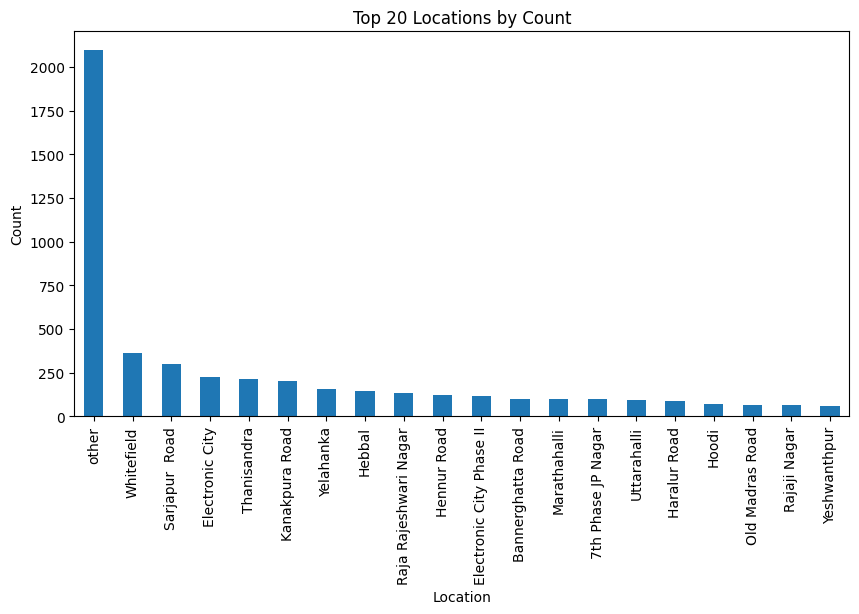

In [36]:
plt.figure(figsize=(10,5))
df['location'].value_counts().head(20).plot(kind='bar')
plt.title("Top 20 Locations by Count")
plt.xlabel("Location")
plt.ylabel("Count")
plt.show()

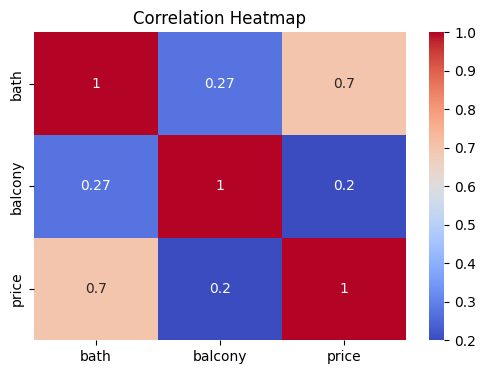

In [37]:
numeric_df = df[['bath', 'balcony', 'price']]
plt.figure(figsize=(6,4))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [20]:
X = df[['location', 'total_sqft', 'bath', 'bhk']]
y = df['price']


In [21]:
transform = ColumnTransformer([
    ('loc', OneHotEncoder(handle_unknown='ignore'), ['location']),
    ('num', StandardScaler(), ['total_sqft', 'bath', 'bhk'])
])


In [22]:
model = Pipeline([
    ('preprocess', transform),
    ('xgb', XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_alpha=0.3,
        reg_lambda=1.0,
        random_state=42
    ))
])


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [25]:
print("Final R2 Score:", round(r2_score(y_test, pred), 4))

Final R2 Score: 0.8729


In [38]:
import joblib
joblib.dump(model, "bangalore_xgb_model.pkl")
print("Model Saved!")


Model Saved!
